In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage import interpolation as inter
import pytesseract

In [62]:
def load_and_binarize_image(image_path):
    img = cv.imread(image_path, 0)  # Load in grayscale
    _, binarized = cv.threshold(img, 200, 255, cv.THRESH_BINARY)
    return binarized

In [63]:
def get_negative_image(binarized):
    return 255 - binarized

In [64]:
def extract_connected_components(negative_img):
    num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(negative_img, connectivity=8)
    return num_labels, labels, stats, centroids

In [120]:
def select_candidate_points(labels, stats, centroids, strategy='centers'):
    candidate_points = []
    
    if strategy == 'centers':
        for c in centroids:
            candidate_points.append((int(c[0]), int(c[1])))
    
    elif strategy == 'max_y':
        for i in range(1, len(stats)):  # Skip the background
            component_mask = (labels == i)  # Get mask of connected component
            y_indices, x_indices = np.where(component_mask)  # Get indices of all pixels in the component
            
            if len(y_indices) > 0:
                max_y_idx = np.argmax(y_indices)  # Find the index of the maximum y-coordinate
                max_x = x_indices[max_y_idx]      # Corresponding x-coordinate
                max_y = y_indices[max_y_idx]      # Maximum y-coordinate
                
                candidate_points.append((max_x, max_y))
    
    elif strategy == 'all':
        candidate_points = np.argwhere(labels > 0)
        candidate_points = [(int(pt[1]), int(pt[0])) for pt in candidate_points]
    
    return candidate_points

In [7]:
def remove_non_candidate_points(negative_img, candidate_points):
    result = np.zeros_like(negative_img)
    for point in candidate_points:
        result[point[1], point[0]] = 255
    return result

In [8]:
def hough_transform(negative_img, threshold = 15):
    lines = cv.HoughLines(negative_img, 1, np.pi / 180, threshold)
    angles = [line[0][1] for line in lines]
    median_angle = np.median(angles)
    #document_angle = (median_angle - np.pi / 2) * 180 / np.pi
    document_angle = ((median_angle - (np.pi / 2)) * 180) / math.pi
    return document_angle

In [9]:
def deskew_image(image_path, angle):
    img = cv.imread(image_path)
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)
    return rotated

In [10]:
def perform_ocr(image):
    return pytesseract.image_to_string(image)

In [11]:
def convert_to_pdf(image, output_path):
    pdf = pytesseract.image_to_pdf_or_hocr(image, extension='pdf')
    with open(output_path, 'w+b') as f:
        f.write(pdf)

In [161]:
# Function to display images using matplotlib
def display_images(images, titles, cmap='gray'):
    plt.figure(figsize=(15, 8))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.title(titles[i])
        plt.axis('off')  # Turn off the axis ticks
    plt.show()

In [121]:
# Load and process the image
image_path = 'doc.jpg'
binarized = load_and_binarize_image(image_path)
negative_img = get_negative_image(binarized)
num_labels, labels, stats, centroids = extract_connected_components(negative_img)

In [122]:
# Perform OCR on actual image
ocr_result_skewed = perform_ocr(cv.imread(image_path))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed)

OCR Result for Skewed Image:
4 deman on 3D data analysis Howeve, ten hap.
num @ PoSterion; Pens that the 3p data Cannot be Obtaj, lalit
e co "8 SPondin, MRE “Wationay Shown in Fig, ),
L PProximation lechnigy e is adopre Or the MAp Speci
€Stimation, The Proposed Method Valuated On both this
Wificial data nd ye ata obtained OM re, "SIrUCtion
Practical Scenes. xpering Fesults have OWN rh,
Obustness and e CNCY of 1 Propose, Nethg, ? Fepaip.
ing NOISY ang ‘Nncon le BD s,
1. Introduction
IPtion
Suppose we €N a sep of PR Mages of re Onstructeg
AN Objecy Capt t multip} View, ints, ct in the
Feal wory, i Pace) ig nl ren NStructe, ing some Relateg Work
3D re, struct, S0rithm, Td ally, objec; Can be op,
"Ved in RGR, -D Mages, it can M Reeonstructors Exist Pe Comp] On @PProache, rE Use of, Seo.
Wever, in © have foung that the "Construction Metric in, Presenteg at either |, “vel or high
Often £ “ven if the R BARG, “D data ig Complete. This evel, Scribes fy wuctures, @
5 becaus, the thing OF the Ri 

In [123]:
#Measuring speed and accuracy of 'Centers'
import time
start_time_center = time.time()

candidate_points_centers = select_candidate_points(labels, stats, centroids)
cleaned_negative_img_centers = remove_non_candidate_points(negative_img, candidate_points_centers)
document_angle_centers = hough_transform(cleaned_negative_img_centers)
deskewed_image_centers = deskew_image(image_path, document_angle_centers)
ocr_result_deskewed_centers = perform_ocr(deskewed_image_centers)

end_time_centers = time.time()
elapsed_time_centers = end_time_centers - start_time_center
print("Time taken by strategy = Centers: ", elapsed_time_centers)

Time taken by strategy = Centers:  5.371365070343018


In [124]:
cv.imwrite('negative_image_centers.png', cleaned_negative_img_centers)
cv.imwrite('deskewed_image_centers.png', deskewed_image_centers)

True

In [125]:
#pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [126]:
# Convert to PDF
convert_to_pdf(cv.imread(image_path), 'skewed_document.pdf')
convert_to_pdf(deskewed_image_centers, 'deskewed_document_centers.pdf')

In [127]:
print("\nOCR Result for Deskewed Image, strategy = centers:")
print(ocr_result_deskewed_centers)


OCR Result for Deskewed Image, strategy = centers:
This CVPE

A Field Model for Repairing 3D Shapes*

Duc Thanh Nguyen’, Binh-Son Hua, Minh-Khoi Tran”, Quang-Hieu Pham’, and Sai-Kit Yeung?
1§chool of Information Technology, Deakin University, Australia
?Singapore University of Technology and Design, Singapore

Abstract

This paper proposes a field model for repairing 3D
shapes constructed from multi-view RGB data. Specifically,
we represent a 3D shape in a Markov random field (MRF) in
which the geometric information is encoded by random bi-
nary variables and the appearance information is retrieved
from a set of RGB images captured at multiple viewpoints.
The local priors in the MRF model capture the local struc-
tures of object shapes and are learnt from 3D shape tem-
plates using a convolutional deep belief network. Repair-
ing a 3D shape is formulated as the maximum a posteriori
(MAP) estimation in the corresponding MRF. Variational
mean field approximation technique is adopted for

In [128]:
#Tmeasuring speed and accuracy of 'max_y'
start_time_max_y = time.time()

candidate_points_max_y = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_max_y = remove_non_candidate_points(negative_img, candidate_points_max_y)
document_angle_max_y = hough_transform(cleaned_negative_img_max_y)
deskewed_image_max_y = deskew_image(image_path, document_angle_max_y)
ocr_result_deskewed_max_y = perform_ocr(deskewed_image_max_y)

end_time_max_y = time.time()
elapsed_time_max_y = end_time_max_y - start_time_max_y
print("Time taken by strategy = Max y: ", elapsed_time_max_y)

Time taken by strategy = Max y:  70.80184078216553


In [129]:
cv.imwrite('negative_image_max_y.png', cleaned_negative_img_max_y)
cv.imwrite('deskewed_image_max_y.png', deskewed_image_max_y)

True

In [130]:
# Convert to PDF
convert_to_pdf(deskewed_image_max_y, 'deskewed_document_max_y.pdf')

In [131]:
print("\nOCR Result for Deskewed Image, strategy = max_y:")
print(ocr_result_deskewed_max_y)


OCR Result for Deskewed Image, strategy = max_y:
This CVPE

A Field Model for Repairing 3D Shapes*

Duc Thanh Nguyen’, Binh-Son Hua, Minh-Khoi Tran”, Quang-Hieu Pham’, and Sai-Kit Yeung?
1§chool of Information Technology, Deakin University, Australia
?Singapore University of Technology and Design, Singapore

Abstract

This paper proposes a field model for repairing 3D
shapes constructed from multi-view RGB data. Specifically,
we represent a 3D shape in a Markov random field (MRF) in
which the geometric information is encoded by random bi-
nary variables and the appearance information is retrieved
from a set of RGB images captured at multiple viewpoints.
The local priors in the MRF model capture the local struc-
tures of object shapes and are learnt from 3D shape tem-
plates using a convolutional deep belief network. Repair-
ing a 3D shape is formulated as the maximum a posteriori
(MAP) estimation in the corresponding MRF. Variational
mean field approximation technique is adopted for t

In [132]:
#measuring speed and accuracy of "all"
start_time_all = time.time()

candidate_points_all = select_candidate_points(labels, stats, centroids, strategy='all')
cleaned_negative_img_all = remove_non_candidate_points(negative_img, candidate_points_all)
document_angle_all = hough_transform(cleaned_negative_img_all)
deskewed_image_all = deskew_image(image_path, document_angle_all)
ocr_result_deskewed_all = perform_ocr(deskewed_image_all)

end_time_all = time.time()
elapsed_time_all = end_time_all - start_time_all
print("Time taken by strategy = all: ", elapsed_time_all)

Time taken by strategy = all:  2.9022371768951416


In [133]:
cv.imwrite('negative_image_all.png', cleaned_negative_img_all)
cv.imwrite('deskewed_image_all.png', deskewed_image_all)

True

In [134]:
# Convert to PDF
convert_to_pdf(deskewed_image_all, 'deskewed_document_all.pdf')

In [135]:
print("\nOCR Result for Deskewed Image, strategy = all:")
print(ocr_result_deskewed_all)


OCR Result for Deskewed Image, strategy = all:



- Time taken by strategy = **Centers:**  5.371365070343018
- Time taken by strategy = **Max y:**  70.80184078216553
- Time taken by strategy = **all:**  2.9022371768951416

In [136]:
# Varying Threshold
# Define the function to run the experiment with varying threshold values
def run_experiment(threshold_values, strategy_name):
    for threshold in threshold_values:
        print(f"\nRunning experiment with threshold = {threshold} and strategy = {strategy_name}:")

        # Start timing
        start_time = time.time()

        # Select candidate points based on the strategy
        candidate_points = select_candidate_points(labels, stats, centroids, strategy=strategy_name)
        cleaned_negative_img = remove_non_candidate_points(negative_img, candidate_points)

        # Apply Hough transform with the given threshold
        document_angle = hough_transform(cleaned_negative_img, threshold=threshold)

        # Deskew the image using the calculated angle
        deskewed_image = deskew_image(image_path, document_angle)

        # Perform OCR on the deskewed image
        ocr_result = perform_ocr(deskewed_image)

        # End timing
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Output the results
        print(f"Time taken: {elapsed_time:.4f} seconds")
        print(f"Document Angle (in degrees): {document_angle:.2f}")
        print("\nOCR Result:")
        print(ocr_result)

In [137]:
# Experiment with three threshold values
threshold_values = [5, 10, 15, 20]

In [138]:
# Experiment with strategy = centers
print("Experiment for Strategy = Centers")
run_experiment(threshold_values, strategy_name='centers')

Experiment for Strategy = Centers

Running experiment with threshold = 5 and strategy = centers:
Time taken: 1.7561 seconds
Document Angle (in degrees): -1.00

OCR Result:


Running experiment with threshold = 10 and strategy = centers:
Time taken: 2.1491 seconds
Document Angle (in degrees): -15.00

OCR Result:
4 hp
wigs, fas
elbogg
Msi 1g Ng,
Use6 “ion, es or
ye dena, (0,
2o, 19, ang
renee Ke,
Ole ‘d Lesa, °S
Won "Paine it
Can be Us fy
Yer, a
RG,
CB. Mage, or
Wy ing de Bjeo, Dep
y ne si,
Rony ayy, es
d. CR (Ge toan be
Wey, ° tn, ty Beane
” bay. Len, ir
Pea Le
Yon ba,



Running experiment with threshold = 15 and strategy = centers:
Time taken: 5.1444 seconds
Document Angle (in degrees): 10.00

OCR Result:
This CVPE

A Field Model for Repairing 3D Shapes*

Duc Thanh Nguyen’, Binh-Son Hua, Minh-Khoi Tran”, Quang-Hieu Pham’, and Sai-Kit Yeung?
1§chool of Information Technology, Deakin University, Australia
?Singapore University of Technology and Design, Singapore

Abstract

This paper pr

Running experiment with threshold = 15 and strategy = centers:  
Time taken: 5.1444 seconds

Running experiment with threshold = 20 and strategy = centers:<br>
Time taken: 7.3379 seconds

In [31]:
#Experiment with stretegy = Max y
print("\nExperiment for Strategy = Max y")
run_experiment(threshold_values, strategy_name='max_y')


Experiment for Strategy = Max y

Running experiment with threshold = 10 and strategy = max_y:
Time taken: 1.4301 seconds
Document Angle (in degrees): -25.00

OCR Result:


Running experiment with threshold = 15 and strategy = max_y:
Time taken: 3.6080 seconds
Document Angle (in degrees): 10.00

OCR Result:
This CVPE

A Field Model for Repairing 3D Shapes*

Duc Thanh Nguyen’, Binh-Son Hua, Minh-Khoi Tran”, Quang-Hieu Pham’, and Sai-Kit Yeung?
1§chool of Information Technology, Deakin University, Australia
?Singapore University of Technology and Design, Singapore

Abstract

This paper proposes a field model for repairing 3D
shapes constructed from multi-view RGB data. Specifically,
we represent a 3D shape in a Markov random field (MRF) in
which the geometric information is encoded by random bi-
nary variables and the appearance information is retrieved
from a set of RGB images captured at multiple viewpoints.
The local priors in the MRF model capture the local struc-
tures of object sha

Running experiment with threshold = 15 and strategy = max_y:  
Time taken: 3.6080 seconds

Running experiment with threshold = 20 and strategy = max_y:  
#Time taken: 3.7948 seconds

In [139]:
#Experiment with stretegy = All
print("\nExperiment for Strategy = All")
run_experiment(threshold_values, strategy_name='all')


Experiment for Strategy = All

Running experiment with threshold = 5 and strategy = all:
Time taken: 3.0370 seconds
Document Angle (in degrees): -5.00

OCR Result:


Running experiment with threshold = 10 and strategy = all:
Time taken: 2.9414 seconds
Document Angle (in degrees): -6.00

OCR Result:


Running experiment with threshold = 15 and strategy = all:
Time taken: 2.6198 seconds
Document Angle (in degrees): -6.00

OCR Result:


Running experiment with threshold = 20 and strategy = all:
Time taken: 2.3931 seconds
Document Angle (in degrees): -7.00

OCR Result:
2




The best results are shown by the following set of parameters.

Threshold = 15, 
Strategy = max_y

These parameters give the best result in the shortest amount of time

Below are the test reults of 5 document images with the best parameters and strategies

Threshold = 15, 
Strategy = max_y

### Testing on images with different orientation

In [164]:
#TESTING ON LOCAL IMAGE test.jpg
# Load and process the image
image_path_test = 'test.jpg'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [165]:
#Strategy = centers
candidate_points_maxY_test = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxY_test = remove_non_candidate_points(negative_img_test, candidate_points_maxY_test)
cv.imwrite('negative_image_maxY_test.png', cleaned_negative_img_maxY_test)

True

In [166]:
# Detect skew and deskew the image
document_angle_maxY_test = hough_transform(cleaned_negative_img_maxY_test, threshold=15)
deskewed_image_maxY_test = deskew_image(image_path_test, document_angle_maxY_test)
cv.imwrite('deskewed_image_maxY_test.png', deskewed_image_maxY_test)

True

In [167]:
#Perform OCR on skewed version
ocr_result_skewed_test = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test)

OCR Result for Skewed Image:



In [168]:
# Perform OCR
ocr_result_deskewed_maxY_test = perform_ocr(deskewed_image_maxY_test)
print("\nOCR Result for Deskewed Image, strategy = Max y:")
print(ocr_result_deskewed_maxY_test)


OCR Result for Deskewed Image, strategy = Max y:
Lorem ipsum dolor sit amet, consectetur adipisicing elit, sed

do eiusmod tempor incididunt ut labore et dolore magna aliqua.
Ut enim ad minim veniam, quis nostrud exercitation ullamco
laboris nisi ut aliquip ex ea commodo consequat.

Duis aute irure dolor in reprehenderit in voluptate velit esse
cillum dolore eu fugiat nulla pariatur.

Excepteur sint occaecat cupidatat non proident, sunt in culpa
qui officia deserunt mollit anim id est laborum,



In [169]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxY_test  # Deskewed image

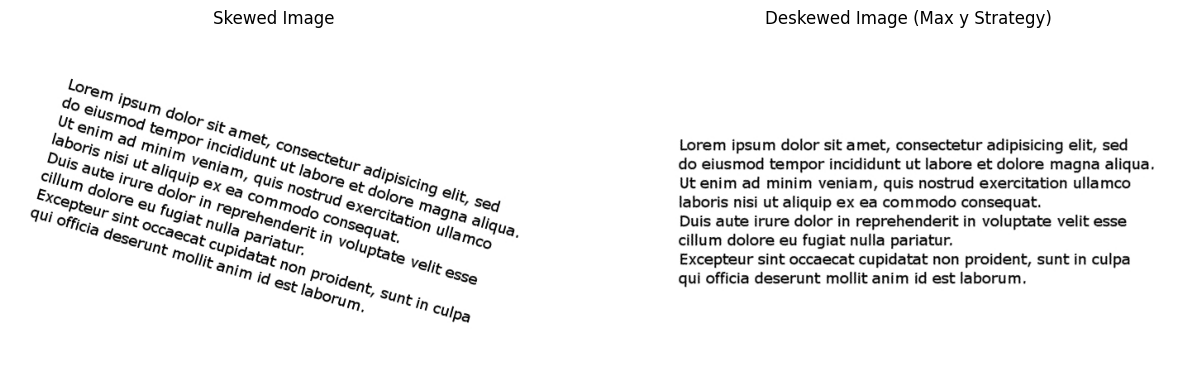

In [170]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

In [171]:
#TESTING ON LOCAL IMAGE test2.jpg
# Load and process the image
image_path_test = 'test2.png'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [172]:
#Strategy = centers
candidate_points_maxy_test2 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test2 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test2)
cv.imwrite('negative_image_maxy_test2.png', cleaned_negative_img_maxy_test2)

True

In [173]:
# Detect skew and deskew the image
document_angle_maxy_test2 = hough_transform(cleaned_negative_img_maxy_test2, threshold=15)
deskewed_image_maxy_test2 = deskew_image(image_path_test, document_angle_maxy_test2)
cv.imwrite('deskewed_image_maxy_test2.png', deskewed_image_maxy_test2)

True

In [174]:
#Perform OCR on skewed version
ocr_result_skewed_test2 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test2)

OCR Result for Skewed Image:
Photo (for example the text on sig
*t superimposed on an image (for es

" from subtitle te;

! whether from a
ns and

xample: from a

whether passport documents,




In [175]:
# Perform OCR
ocr_result_deskewed_maxy_test2 = perform_ocr(deskewed_image_maxy_test2)
print("\nOCR Result for Deskewed Image, strategy = Max y:")
print(ocr_result_deskewed_maxy_test2)


OCR Result for Deskewed Image, strategy = Max y:
Optical character recognition or optical character reader (OCR) is the electronic or mechanical
conversion of images of typed, handwritten or printed text into machine-encoded text, whether froma
scanned document, a photo of a document, a scene-photo (for example the text on signs and
billboards in a landscape photo) or from subtitle text superimposed on an image (for example: from a
television broadcast).

Widely used as a form of data entry from printed paper data records - whether passport documents,

invoices, bank statements, computerized receipts, business cards, mail, printouts of static-data, or any
suitable documentation —it is a common method of digitizing printed texts so that they can be

electronically edited, searched, stored more compactly, displayed on-line, and used in machine
processes such as cognitive computing, machine translation, (extracted) text-to-speech, key data and
text mining. OCR is a field of research in p

In [176]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test2  # Deskewed image

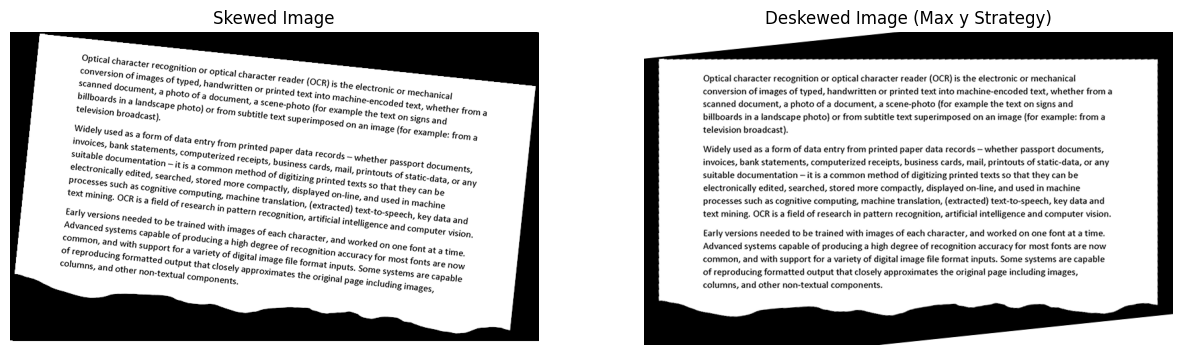

In [177]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

In [179]:
#TESTING ON LOCAL IMAGE test4.png
# Load and process the image
image_path_test = 'test4.png'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [180]:
#Strategy = centers
candidate_points_maxy_test4 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test4 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test4)
cv.imwrite('negative_image_maxy_test4.png', cleaned_negative_img_maxy_test4)

True

In [181]:
# Detect skew and deskew the image
document_angle_maxy_test4 = hough_transform(cleaned_negative_img_maxy_test4, threshold=15)
deskewed_image_maxy_test4 = deskew_image(image_path_test, document_angle_maxy_test4)
cv.imwrite('deskewed_image_maxy_test4.png', deskewed_image_maxy_test4)

True

In [182]:
#Perform OCR on skewed version
ocr_result_skewed_test4 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test4)

OCR Result for Skewed Image:



In [183]:
# Perform OCR
ocr_result_deskewed_maxy_test4 = perform_ocr(deskewed_image_maxy_test4)
print("\nOCR Result for Deskewed Image, strategy = Max y:")
print(ocr_result_deskewed_maxy_test4)


OCR Result for Deskewed Image, strategy = Max y:
Ashish Vaswani* Noam Shazeer* Niki Parmar* Jakob Uszkoreit*
Google Brain Google Brain Google Research Google Research
avaswani@google.com noam@google.com nikip@google.com usz@google.com

Llion Jones* Aidan N. Gomez* * Lukasz Kaiser*
Google Research University of Toronto Google Brain
llion@google.com aidan@cs.toronto.edu lukaszkaiser@google.com

Illia Polosukhin* ?
illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks that include an encoder and a decoder. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer,
based solely on attention mechanisms, dispensing with recurrence and convolutions
entirely. Experiments on two machine translation tasks show these models to
be superior in quality while being more parallelizable and requiring significantly


In [184]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test4  # Deskewed image

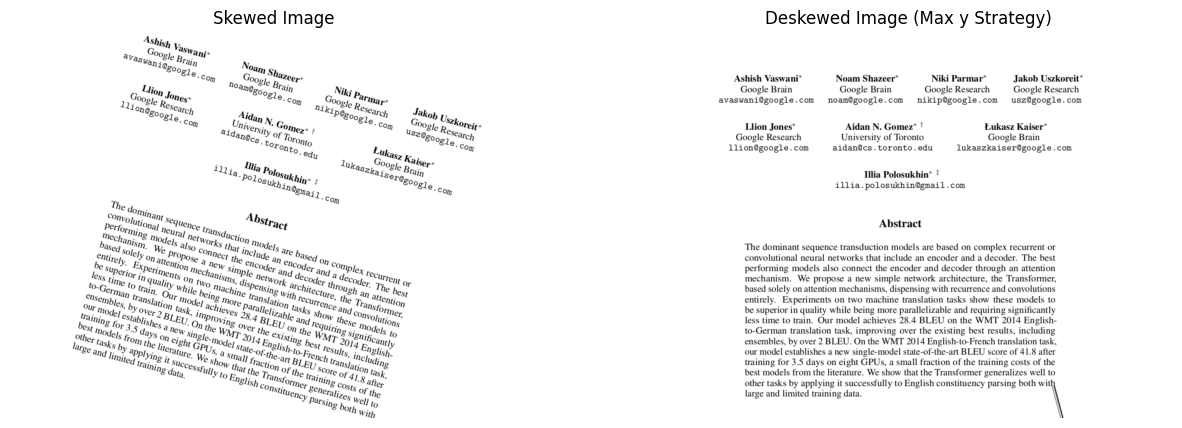

In [185]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

In [186]:
#TESTING ON LOCAL IMAGE test7.png, Different orientation
# Load and process the image
image_path_test = 'test7.png'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [188]:
#Strategy = max_y
candidate_points_maxy_test7 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test7 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test7)
cv.imwrite('negative_image_maxy_test7.png', cleaned_negative_img_maxy_test7)

True

In [189]:
# Detect skew and deskew the image
document_angle_maxy_test7 = hough_transform(cleaned_negative_img_maxy_test7, threshold=15)
deskewed_image_maxy_test7 = deskew_image(image_path_test, document_angle_maxy_test7)
cv.imwrite('deskewed_image_maxy_test7.png', deskewed_image_maxy_test7)

True

In [190]:
#Perform OCR on skewed version
ocr_result_skewed_test7 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test7)

OCR Result for Skewed Image:
enoyncerna. vot #2 NO" _nuare@AUARY 20

srocn008 moo
matical Inference

Natural Language Gram
with Recurrent Neural Networks

1 IEEE, C. Lee Giles: Fellow.

eee TRANEACTIONS

IEEE, and Sandiway Fons

gteve Lawrence, Membe!
rads pe aT ea rnc car IE et seca, ve wsk consid
neat vaneg ante OORT wa anguae See etl nara emcee sae
stl ss pe lam Fag varnont of GOFOTENS ying eon. Now
oe rene we ee onroveared en org rece ST
cere anne oak pavly great ea oseaas tngushe
sy ane corn ns ai
cae ch 8 OS a feat Howe ering seve
ving comes Sayieant
ores ore sero oon oe
ae er eri gated.

oeriaues ere 8
tcl new “Seri rere
enon = Wejyre. Fry.

sjornce, goverment on

4 twrRODUCTION
vas paper corer: He of dassifying cater! ait ees a7 Ey the networks
engage semienecs 28 ramonatical OF siiamatical. and the Na whee an invests cexteaction.
tame to ter neural Se ‘oithont the bifurea 1S paper nengacized 28 FN Bean 2 provides He
We ante, Harned ve MOE vormponents assumed PY peta oe the tas

In [191]:
# Perform OCR
ocr_result_deskewed_maxy_test7 = perform_ocr(deskewed_image_maxy_test7)
print("\nOCR Result for Deskewed Image, strategy = Max Y:")
print(ocr_result_deskewed_maxy_test7)


OCR Result for Deskewed Image, strategy = Max Y:
28 EGE TRANSACTIONS ON KNOWLEDOE AND DATA ENGNGERING, VOL 12, NO. 1

Natural Language Grammatical Inference
with Recurrent Neural Networks

Steve Lawrence, Member, IEEE, C. Lee Giles, Fellow, IEEE, and Sandiway Fong

[Abstract—This pape examin te induc inference ot complex yamvmar wit court netwons—-epocticaly. the ask considered
‘Sita of raning« etwor to casily natural angatgesectences as Grarmatcl cr ungrammatal Crereby exhating the same kid
‘ot ascomnatoy power proved by the Prtieplee and Parameers lagu tamewank of Govereen-and Sieg theory. Nora!
‘etworks ar vaied, wou te vison mo tearied\e nate components assumed by Chomsky, nbn altempt to produce he ame
yhgmeonts as nave epaakors on thal gamumatcarungrarmascal data. How a recent neva netwck coud postass Ingus
Capabity andthe properties of variove common recurs mural tatwork arctan are discussed. Te problom exis Waning
tenavor whch 9 te oot erecent wah emaber grammare an! Waning wes

In [193]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test7  # Deskewed image

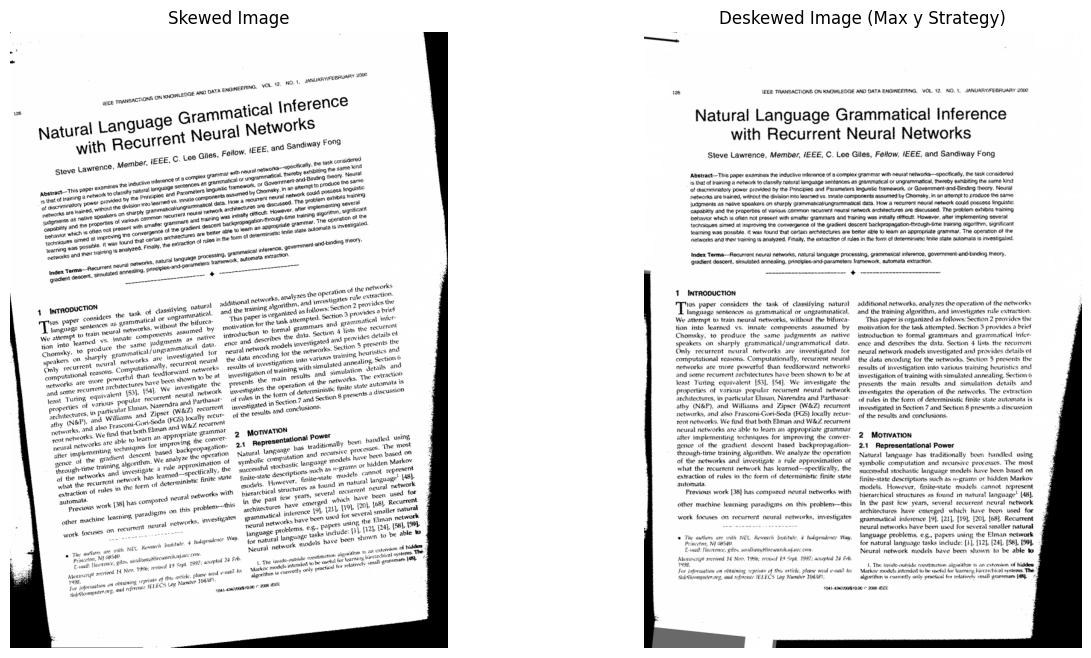

In [194]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

In [195]:
#TESTING ON LOCAL IMAGE test10.jpg, Different orientation
# Load and process the image
image_path_test = 'test10.jpg'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [196]:
#Strategy = max_y
candidate_points_maxy_test10 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test10 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test10)
cv.imwrite('negative_image_maxy_test10.png', cleaned_negative_img_maxy_test10)

True

In [197]:
# Detect skew and deskew the image
document_angle_maxy_test10 = hough_transform(cleaned_negative_img_maxy_test10, threshold=15)
deskewed_image_maxy_test10 = deskew_image(image_path_test, document_angle_maxy_test10)
cv.imwrite('deskewed_image_maxy_test10.png', deskewed_image_maxy_test10)

True

In [198]:
#Perform OCR on skewed version
ocr_result_skewed_test10 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test10)

OCR Result for Skewed Image:
Lorem ipsum dolor sit amet, consectetur radii ng elit,
do eiusmod tempor incididunt ut labore et det magna qua.
utenim ad minim veniam, quis nostrud ex! piorsuon ullamco

\aboris nisi ut aliquip eX ea commodo cons' sequal
Duis aute irure dotor in reprenen nderit in woluptate te velit esse

excepteur sint oc aecat cupidatat non prol roident, sunt in culpa
qui officia deserunt mollit anim id est Jaborum.



In [199]:
# Perform OCR
ocr_result_deskewed_maxy_test10 = perform_ocr(deskewed_image_maxy_test10)
print("\nOCR Result for Deskewed Image, strategy = Max Y:")
print(ocr_result_deskewed_maxy_test10)


OCR Result for Deskewed Image, strategy = Max Y:
Lorem ipsum dolor sit amet, consectetur adipisicing elit, sed

do eiusmod tempor incididunt ut labore et dolore magna aliqua.
Ut enim ad minim veniam, quis nostrud exercitation ullamco
laboris nisi ut aliquip ex ea commodo consequat.

Duis aute irure dolor in reprehenderit in voluptate velit esse
cillum dolore eu fugiat nulla pariatur.

Excepteur sint occaecat cupidatat non proident, sunt in culpa
qui officia deserunt mollit anim id est laborum.



In [200]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test10  # Deskewed image

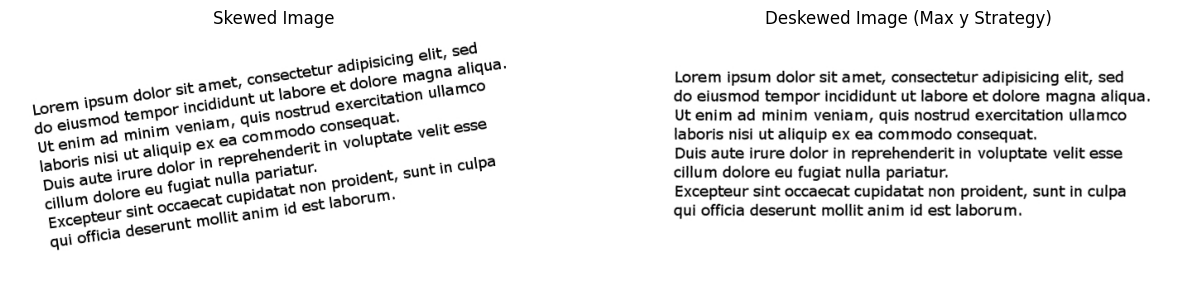

In [201]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

In [ ]:
#Testing on different Language

In [202]:
#TESTING ON LOCAL IMAGE test6.png, Different language
# Load and process the image
image_path_test = 'test6.png'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [204]:
#Strategy = centers
candidate_points_maxy_test6 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test6 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test6)
cv.imwrite('negative_image_maxy_test6.png', cleaned_negative_img_maxy_test6)

True

In [206]:
# Detect skew and deskew the image
document_angle_maxy_test6 = hough_transform(cleaned_negative_img_maxy_test6, threshold=10)
deskewed_image_maxy_test6 = deskew_image(image_path_test, document_angle_maxy_test6)
cv.imwrite('deskewed_image_maxy_test6.png', deskewed_image_maxy_test6)

True

In [ ]:
'''
For this case I had to change the threshold value as the chosen value of 15 is too high for the lines to be detected by cv.HoughLines().
'''

In [207]:
#Perform OCR on skewed version
ocr_result_skewed_test6 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test6)

OCR Result for Skewed Image:
SC, dey
le 4
ow. Wigs we aS
50 Rasta )

4 Sy, ie 3
Pa “diag Se 2 ais, oes
Mg ha tLe See,
ea ie fe ag, he, WI ae 8s iy
tos iy ie 4 ls SS, om, Shy



In [210]:
# Perform OCR
ocr_result_deskewed_maxy_test6 = perform_ocr(deskewed_image_maxy_test6)
print("\nOCR Result for Deskewed Image, strategy = Max Y:")
print(ocr_result_deskewed_maxy_test6)


OCR Result for Deskewed Image, strategy = Max Y:
gg phe a Taba gi da rine sot gale Jlge a g9ad * oe 59 sob Ian baat
gileins tty Ja Sarbeal a SS j 98 Nagar Surg al ped ppaloar de sachs
plan (254 eS 8a glide Ilion 2 Sy ae grt in tnged ulelen
PAI, a gh SI g4 9A S tpn Ba gsbl 9 SI gh lal ay had of Slew pr a5
Pen ge Saab | ln AE Ay gt Misleme My sty gel + geal Gat 9S
“apd gle

Be ie et He AS ald Galle sl les eS ile gn?
yd Shee Sed Seb ag LD SOS 9 si Ai cs gt 5S seed 39-099 es
Getyglys eal pened oF 2 MS sl alse So9? I eal sl got dail sl got
sesh bs ge rssh ITP oe ged FOIE irs ET grey oe 4g?
Oso p tetyhe al gtd eany hay 2 alle 0S 005 gh Gl ay MSD 395 sit 2959
DSS ey sal gt 6 pats ee bl porte shyt ghd cllgeg Kix ee
Pia al gh hee 2 ge Go ag ee gay AaB Dg tl oe Lb 35 9 gab pet aS
eh gt HAS Se co tbe) lew Sts - gabe lyst ah Sade tetas Kea, '
shew gle ag olajas NBS bas hoh Te Tipe Applian dees

Aadheg ell



In [211]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test6  # Deskewed image

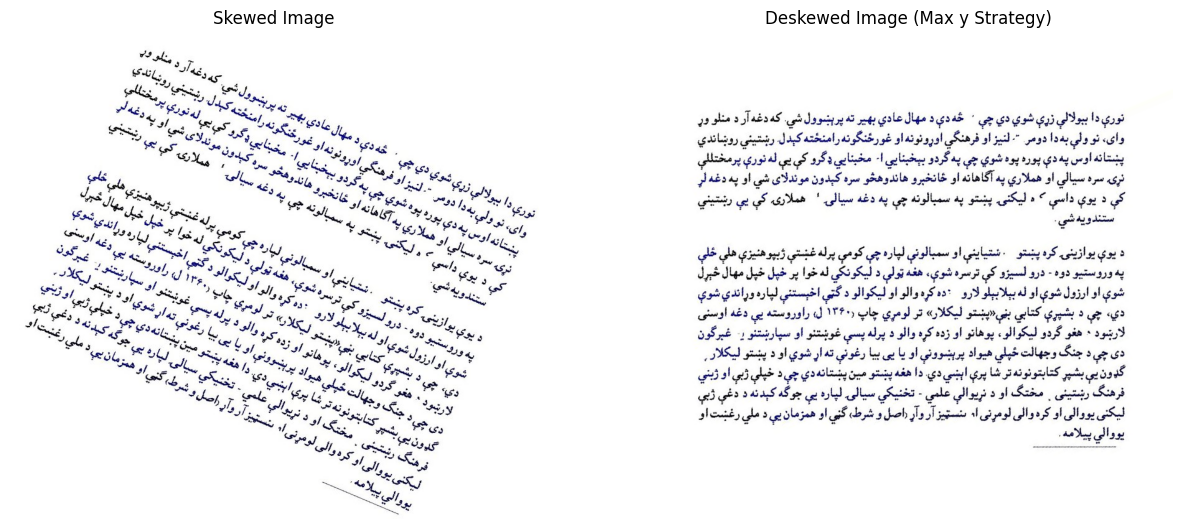

In [212]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

For different language, Houghman transformation was able to deskew the image, but OCR writes gibberish language.

### Nosie Elements in Dosuments

In [213]:
#TESTING ON LOCAL IMAGE test3.jpg
# Load and process the image
image_path_test = 'test3.png'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [214]:
#Strategy = centers
candidate_points_maxy_test3 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test3 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test3)
cv.imwrite('negative_image_maxy_test3.png', cleaned_negative_img_maxy_test3)

True

In [215]:
# Detect skew and deskew the image
document_angle_maxy_test3 = hough_transform(cleaned_negative_img_maxy_test3, threshold=15)
deskewed_image_maxy_test3 = deskew_image(image_path_test, document_angle_maxy_test3)
cv.imwrite('deskewed_image_maxy_test3.png', deskewed_image_maxy_test3)

True

In [216]:
#Perform OCR on skewed version
ocr_result_skewed_test3 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test3)

OCR Result for Skewed Image:
I) Rc oti
Desr.

image. Can help 4 log ip
nt, nd do, OCR G OMR R, barcodes

detection or ost eaPrOve the

Feadabin;" ity Ned j ima



In [219]:
# Perform OCR
ocr_result_deskewed_maxy_test3 = perform_ocr(deskewed_image_maxy_test3)
print("\nOCR Result for Deskewed Image, strategy = Max y:")
print(ocr_result_deskewed_maxy_test3)


OCR Result for Deskewed Image, strategy = Max y:
l . Wid MA AMIN

E Imaging
Deskening an image can help a lot, if
you want to do OCR, OMR, barcode
detection or just improve the
readability of scanned images.



In [220]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test3  # Deskewed image

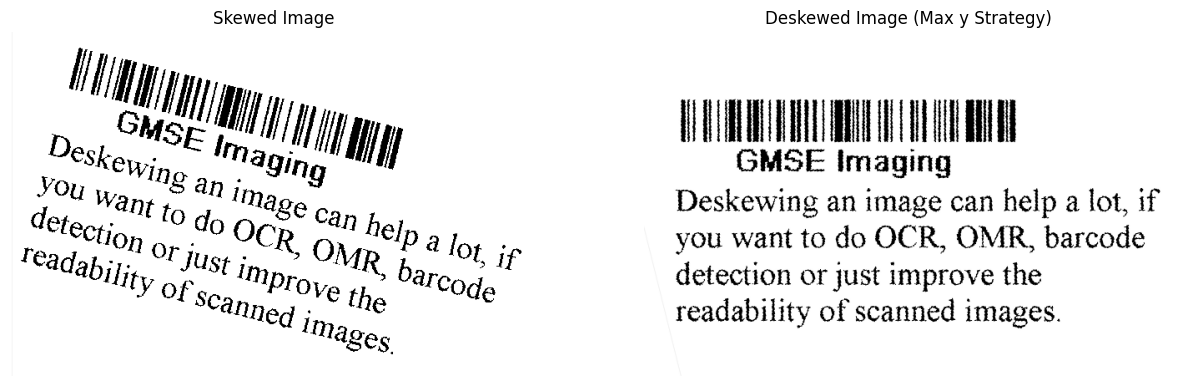

In [221]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

The transformation for noise value(barcode) was successfull.  
The Document image has a barcode, It is detected as, l . Wid MA AMINE, The rest of the text is accurately detected 

In [222]:
#TESTING ON LOCAL IMAGE test5.png
# Load and process the image
image_path_test = 'test5.png'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [223]:
#Strategy = centers
candidate_points_maxy_test5 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test5 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test5)
cv.imwrite('negative_image_maxy_test5.png', cleaned_negative_img_maxy_test5)

True

In [224]:
# Detect skew and deskew the image
document_angle_maxy_test5 = hough_transform(cleaned_negative_img_maxy_test5, threshold=15)
deskewed_image_maxy_test5 = deskew_image(image_path_test, document_angle_maxy_test5)
cv.imwrite('deskewed_image_maxy_test5.png', deskewed_image_maxy_test5)

True

In [225]:
#Perform OCR on skewed version
ocr_result_skewed_test5 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test5)

OCR Result for Skewed Image:



In [226]:
# Perform OCR
ocr_result_deskewed_maxy_test5 = perform_ocr(deskewed_image_maxy_test5)
print("\nOCR Result for Deskewed Image, strategy = Max Y:")
print(ocr_result_deskewed_maxy_test5)


OCR Result for Deskewed Image, strategy = Max Y:
This is a lot of 12 point text to test the
ocr code and see if it works on all types
of file format.

The quick brown dog jumped over the
Wl WB. The quick brown dog jumped
over the J MMM. The quick brown dog
jumped over the [ij MM. The quick
brown dog jumped over the Jj Mx.



In [227]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test5  # Deskewed imagea

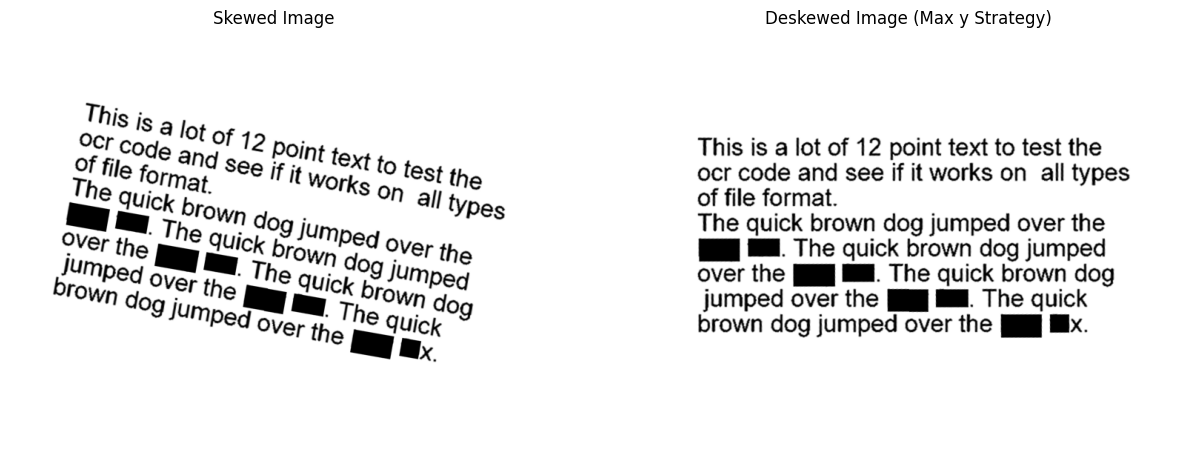

In [228]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

Transformation was successful as the noise elements(strikethrough words) were descewed using Houghman transformation
In this case, there were some wordswhich were strikethrough with thick black layer, these words were detected as Wl, WB,
J, MMM, ij, MM, Jj Mx.

In [229]:
#TESTING ON LOCAL IMAGE test8.png, Different orientation
# Load and process the image
image_path_test = 'test8.png'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [230]:
#Strategy = max_y
candidate_points_maxy_test8 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test8 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test8)
cv.imwrite('negative_image_maxy_test8.png', cleaned_negative_img_maxy_test8)

True

In [231]:
# Detect skew and deskew the image
document_angle_maxy_test8 = hough_transform(cleaned_negative_img_maxy_test8, threshold=15)
deskewed_image_maxy_test8 = deskew_image(image_path_test, document_angle_maxy_test8)
cv.imwrite('deskewed_image_maxy_test8.png', deskewed_image_maxy_test8)

True

In [232]:
#Perform OCR on skewed version
ocr_result_skewed_test8 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test8)

OCR Result for Skewed Image:
Department of Homeland Security
US. Citznship and Immigration Serces

uscis
Form 1-9

eae

blepe deed

SCS Gnmen 1 Cad

cciment) resented byte atovesaned employe,
move names snd) we best ay as te

[err eas w Spina Kane

Soa 3 Specs Aan Gone OR SST

harloceavinte

oepartnene of Agereulcure

ar come

Bors tee eres

Resse

Fem E91aaia019

Paezars



In [233]:
# Perform OCR
ocr_result_deskewed_maxy_test8 = perform_ocr(deskewed_image_maxy_test8)
print("\nOCR Result for Deskewed Image, strategy = Max Y:")
print(ocr_result_deskewed_maxy_test8)


OCR Result for Deskewed Image, strategy = Max Y:
[cae ta a IT Tei TT

ores 72038 wr

1595 cane ak
pumerery
es conse

vs0r9/2000

‘ericnton atest unde pony of paruy at) have examined fe desument( presente Se abovenaned empoye,
Sine tenis sce pn gnu tm unm be cmp oso) e my

(See msrvceors tr evento)

an Resene ——[acaya mevan) [Tin ol oy = ahr Reweais
Z osr182020 i Nanager

ate op pment en = nae apeatn [ervey Bares Opranin Nase

settereen on locparemene of hactoulvuce

Teneo can pn Kanes Stee! me) [aya Tome call dol

12) mtscelto oeive [Suarioccenvitte 22002

aap aan eae nae In nned HARTA Sora AT
[veer Te [Deon omer Son Som anh mT

‘anos ond pay of pay, ate a best wonidge lk ompoye s subordinate a
‘os roves estes aorumane te Socunest have snamned spew be Gene tnd ete Bw ea

Sian Ege ered Reena [Warm pore ond yee

Fen? ai Poet



In [234]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test8  # Deskewed imagea

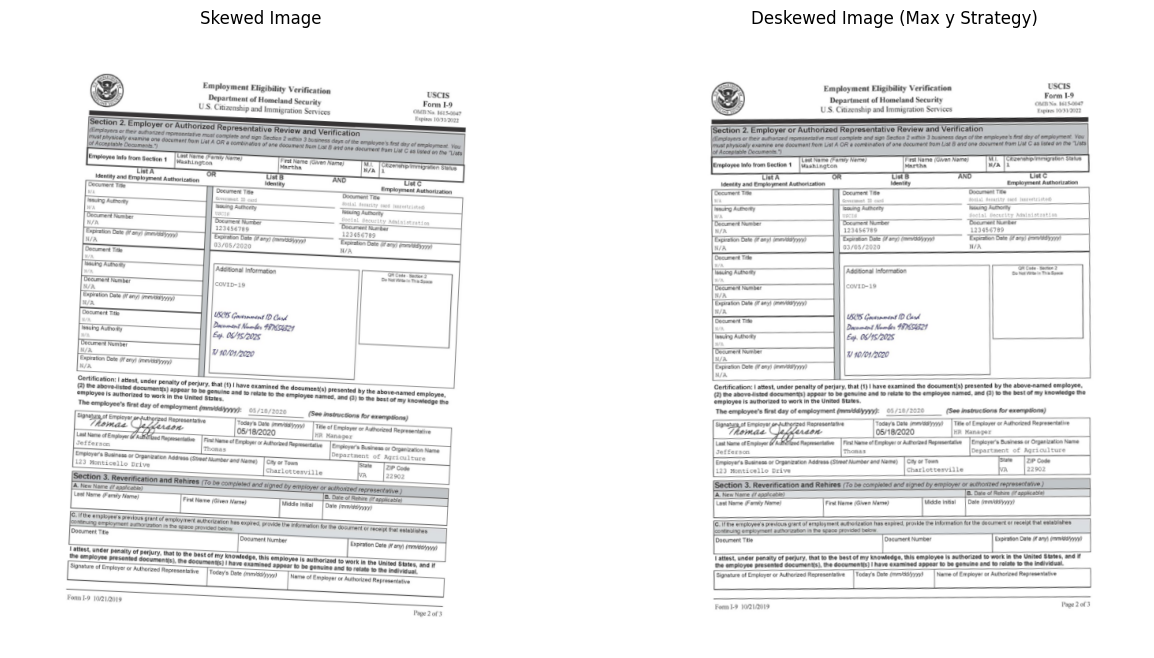

In [235]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

The houghman Transformation is successful in this case, the tabels were deskewed properly along with the texts of different sizes.  
However, due to poor resolution, the OCR was unable to detect the text properly

In [236]:
#TESTING ON LOCAL IMAGE test9.jpg, Different orientation
# Load and process the image
image_path_test = 'test9.jpg'
binarized_test = load_and_binarize_image(image_path_test)
negative_img_test = get_negative_image(binarized_test)
num_labels, labels, stats, centroids = extract_connected_components(negative_img_test)

In [237]:
#Strategy = max_y
candidate_points_maxy_test9 = select_candidate_points(labels, stats, centroids, strategy='max_y')
cleaned_negative_img_maxy_test9 = remove_non_candidate_points(negative_img_test, candidate_points_maxy_test9)
cv.imwrite('negative_image_maxy_test9.png', cleaned_negative_img_maxy_test9)

True

In [238]:
# Detect skew and deskew the image
document_angle_maxy_test9 = hough_transform(cleaned_negative_img_maxy_test9, threshold=15)
deskewed_image_maxy_test9 = deskew_image(image_path_test, document_angle_maxy_test9)
cv.imwrite('deskewed_image_maxy_test9.png', deskewed_image_maxy_test9)

True

In [239]:
#Perform OCR on skewed version
ocr_result_skewed_test9 = perform_ocr(cv.imread(image_path_test))
print("OCR Result for Skewed Image:")
print(ocr_result_skewed_test9)

OCR Result for Skewed Image:
Brewprint : 38




In [240]:
# Perform OCR
ocr_result_deskewed_maxy_test9 = perform_ocr(deskewed_image_maxy_test9)
print("\nOCR Result for Deskewed Image, strategy = Max Y:")
print(ocr_result_deskewed_maxy_test9)


OCR Result for Deskewed Image, strategy = Max Y:



In [243]:
# Load the images to display
skewed_image = cv.imread(image_path_test)  # Skewed image (original)
deskewed_image = deskewed_image_maxy_test9  # Deskewed imagea

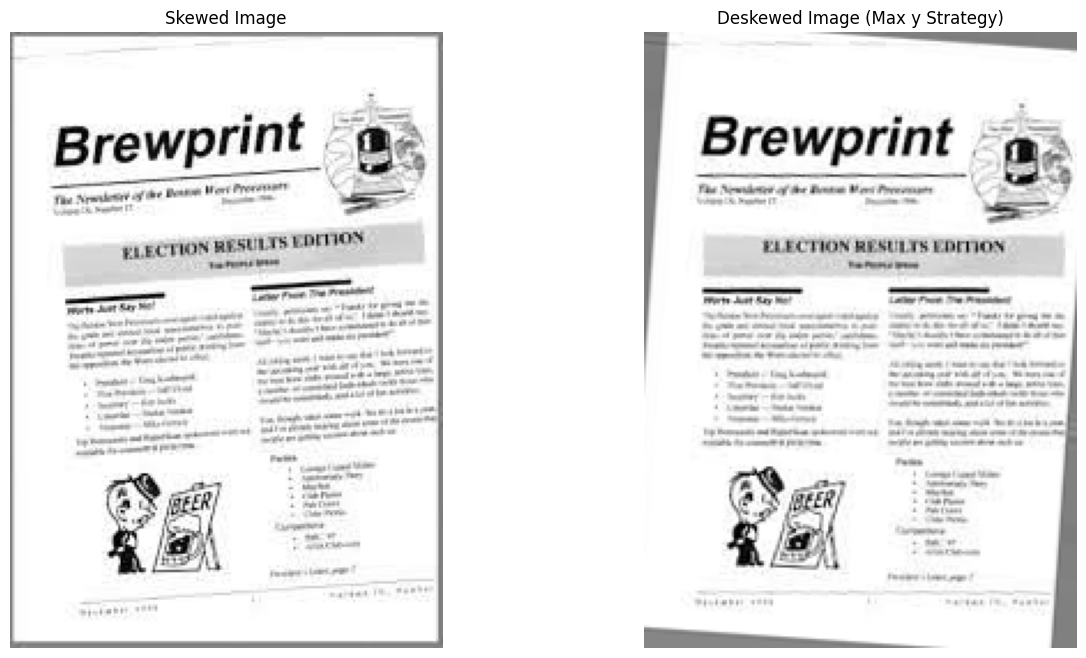

In [244]:
# Display the skewed and deskewed images using matplotlib
images = [skewed_image, deskewed_image]
titles = ['Skewed Image', 'Deskewed Image (Max y Strategy)']
display_images(images, titles)

The transformation is successful, all textual and non textual elements were skewed along with texts of different sizes.